In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mne
import seaborn as sns

from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch
    
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
import pyedflib
import numpy as np
import pandas as pd
from datetime import datetime
from scipy import signal
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import os
import warnings
warnings.filterwarnings('ignore')

## Get filenames in a list

In [2]:
#current_dir = "/home/jupyter/Sleep-EDF/sleep-cassette/"
#current_dir = "/Users/miguelgarcia/Desktop/NGoggle/Sleep-EDF/sleep-cassette/"
current_dir = "C:/Users/Miguel/Desktop/NGoggle/sleep-edf/sleep-cassette/"
subs = 15
files = []
annots = []
for filename in os.listdir(current_dir):
    if filename == '.ipynb_checkpoints':
        continue
    elif filename == '.DS_Store':
        continue
    elif filename == 'SC-subjects.csv':
        continue
    if 'Hypnogram' not in filename and "._" not in filename:
        files.append(filename)
    elif 'Hypnogram' in filename and "._" not in filename:
        annots.append(filename)
files.sort()
annots.sort()
all_s = len(files)
file_dict = dict(zip(files,annots))


## Get the live starting time of sleep cycle

In [3]:
times_of_sleep = pd.read_csv(current_dir + "SC-subjects.csv")
times_of_sleep.columns = ['Subject','Night','Age','Sex','L-off']
times_of_sleep.drop(columns = ['Sex','Age'],inplace = True)

## Starting time of the subjects recording

In [4]:
start_times = []
for i in range(0,all_s):
    f = pyedflib.EdfReader(current_dir+files[i])
    st = ''  
    st = st + str(f.getHeader()['startdate'].hour) + ':'
    st = st + str(f.getHeader()['startdate'].minute) + ':'
    st = st + str(f.getHeader()['startdate'].second)
    start_times.append(st)

## Get the starting time of the sleep cycle

In [5]:
sleep_start = []
for i in range(0,all_s):
    sub = int(files[i][3:5])
    night = int(files[i][5:6])
    sleep_start.append(times_of_sleep[(times_of_sleep.Subject == sub) & (times_of_sleep.Night == night)]['L-off'].iloc[0]+':00')

## Get the starting point and end point in the EDF data

In [6]:
startpoint_edf = []
endpoint_edf = []
FMT = '%H:%M:%S'
for i in range(0,all_s):
    t = datetime.strptime(sleep_start[i], FMT) - datetime.strptime(start_times[i], FMT)
    startpoint_edf.append(int(t.seconds/30))
    endpoint_edf.append(int((t.seconds/30) + 960))

## Initializing the epochs 

In [7]:
all_subs = []
for i in range(0,all_s):
    all_subs.append([current_dir+files[i],current_dir+annots[i]])
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 3,
                              'Sleep stage 4': 3,
                              'Sleep stage R': 1,
                              'Sleep stage ?': 3,
                              'Movement time': 3}
mapping = {'EEG Fpz-Cz':'misc',
           'EEG Pz-Oz':'misc',
           'EOG horizontal': 'eeg',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

In [8]:
raw_train = []
annot_train = []
for i in range(0,all_s):
    raw_train_cur = mne.io.read_raw_edf(all_subs[i][0])
    annot_train_cur = mne.read_annotations(all_subs[i][1])
    raw_train_cur.set_annotations(annot_train_cur, emit_warning=False)
    raw_train_cur.set_channel_types(mapping)
    
    raw_train.append(raw_train_cur)
    annot_train.append(annot_train_cur)

Extracting EDF parameters from C:\Users\Miguel\Desktop\NGoggle\sleep-edf\sleep-cassette\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\Miguel\Desktop\NGoggle\sleep-edf\sleep-cassette\SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\Miguel\Desktop\NGoggle\sleep-edf\sleep-cassette\SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\Miguel\Desktop\NGoggle\sleep-edf\sleep-cassette\SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\Miguel\Desktop\NGoggle\sleep-edf\sleep-cassette\SC4022E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\Migue

## Setting annotations

In [9]:
events_train = []
for i in range(0,all_s):
    events_train.append(mne.events_from_annotations(
    raw_train[i], event_id=annotation_desc_2_event_id, chunk_duration=30.)[0])
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2/Asleep': 3
           }


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage ?', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Movement time', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage ?', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage ?', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage ?', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Movement time', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage ?', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage ?', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stag

In [10]:
def eeg_power_band(epochs):
    # analyze delta, theta, alpha, sigma, and gamma
    final_X = []
    freq_b = [[0.5, 4.5],[4.5, 8.5],[8.5, 11.5], [11.5, 15.5], [15.5, 30]]  
    ps, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.)
    #ps = 10*np.log10(ps)
    ps = ps/np.sum(ps, axis=-1, keepdims=True) #normalize
    for i in freq_b:
        ps_band = ps[:, :, (freqs >= i[0]) & (freqs < i[1])].mean(axis=-1)  #can use median too
        final_X.append(ps_band.reshape(len(ps), -1))
    return np.concatenate(final_X, axis=1)

## Hold all trials in a single array

In [11]:
epochs_train = []
for i in range(0,all_s):
    print(i)
    epochs_train.append(mne.Epochs(raw=raw_train[i], events=events_train[i],
                          event_id=event_id, tmin=0., tmax= (30. - 1. / raw_train[0].info['sfreq']), 
                        baseline=None))

0
2650 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
1
2830 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
2
2802 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
3
2804 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
4
2756 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
5
2820 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
6
2732 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
7
2570 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
8
2792 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
9
2722 mat

## Concatenate all trials to a single mne object

In [12]:
all_epochs = mne.concatenate_epochs([epochs_train[0],epochs_train[1]])
for i in range(2,subs):
    all_epochs = mne.concatenate_epochs([all_epochs,epochs_train[i]])
    print(i, ' subjects loaded succesfully')
    print()
lens = [len(epochs_train[0])]
for i in range(1,subs):
    lens.append(len(epochs_train[i])+lens[i-1])

Loading data for 2650 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 2830 events and 3000 original time points ...
0 bad epochs dropped
5480 matching events found
No baseline correction applied
Not setting metadata
0 bad epochs dropped
Loading data for 2802 events and 3000 original time points ...
0 bad epochs dropped
8282 matching events found
No baseline correction applied
Not setting metadata
0 bad epochs dropped
2  subjects loaded succesfully

Loading data for 2804 events and 3000 original time points ...
0 bad epochs dropped
11086 matching events found
No baseline correction applied
Not setting metadata
0 bad epochs dropped
3  subjects loaded succesfully

Loading data for 2756 events and 3000 original time points ...
0 bad epochs dropped
13842 matching events found
No baseline correction applied
Not setting metadata
0 bad epochs dropped
4  subjects loaded succesfully

Loading data for 2820 events and 3000 original time points ...
0 bad epochs droppe

In [13]:
classifier = RandomForestClassifier(n_estimators = 100, random_state = 23)
pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),classifier)
pipe.fit(all_epochs,all_epochs.events[:,2])
from joblib import dump, load
dump(pipe, 'sleep-onset-alg.pkl')

Effective window size : 2.560 (s)


['sleep-onset-alg.pkl']

## Train algorithm and do leave one out for the training set

In [14]:
pands = []
resting_y_pred = []
resting_y_test = []
big_y_pred = []
big_y_test = []
for i in range(0,subs):
    print(i)
    if i == 0:
        train = all_epochs[lens[0]:]
        test = all_epochs[0:lens[0]]
        y_train = train.events[:,2]
    elif i == len(lens)-1:
        test = all_epochs[lens[len(lens)-2]:]
        train = all_epochs[0:lens[len(lens)-2]]
        y_train = train.events[:,2]
    else:
        test = all_epochs[lens[i-1]:lens[i]]
        train = mne.concatenate_epochs([all_epochs[0:lens[i-1]],all_epochs[lens[i]:]])
        y_train = train.events[:,2]
    params = {"n_estimators": [50,100,200,300]}
    clf = ExtraTreesClassifier(random_state=0)
    classifier = GridSearchCV(clf, params, cv = 10)
    pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),classifier)
    pipe.fit(train,y_train)
    y_pred = pipe.predict(test)
    y_test = test.events[:, 2]
    resting_y_pred.append(y_pred[startpoint_edf[i]:endpoint_edf[i]])
    resting_y_test.append(y_test[startpoint_edf[i]:endpoint_edf[i]])
    big_y_pred.append(y_pred)
    big_y_test.append(y_test)
    conf = confusion_matrix(y_test, y_pred) 
    conf = conf /conf.astype(np.float).sum(axis=1)
    pands.append(pd.DataFrame([y_test[int(startpoint_edf[i]):int(endpoint_edf[i])],
                              y_pred[int(startpoint_edf[i]):int(endpoint_edf[i])]]).T)
    print()

0
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)

1
38464 matching events found
No baseline correction applied
Not setting metadata
0 bad epochs dropped
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)

2
38492 matching events found
No baseline correction applied
Not setting metadata
0 bad epochs dropped
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)

3
38490 matching events found
No baseline correction applied
Not setting metadata
0 bad epochs dropped
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)

4
38538 matching events found
No baseline correction applied
Not setting metadata
0 bad epochs dropped
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)

5
38474 matching events found
No baseline correction applied
Not setting metadata
0 bad epochs dropped
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)

6
38562 matching events found
No baseline correction applied
Not sett

## Do the predictions for the rest of the trials

In [15]:
params = {"n_estimators": [50,100,200,300]}
clf = ExtraTreesClassifier(random_state=0)
classifier = GridSearchCV(clf, params, cv = 10)
pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),classifier)
pipe.fit(all_epochs,all_epochs.events[:,2])
for i in range(subs,all_s):
    print(i)
    test = epochs_train[i]
    y_pred = pipe.predict(test)
    y_test = test.events[:, 2]
    resting_y_pred.append(y_pred[startpoint_edf[i]:endpoint_edf[i]])
    resting_y_test.append(y_test[startpoint_edf[i]:endpoint_edf[i]])
    big_y_pred.append(y_pred)
    big_y_test.append(y_test)
    conf = confusion_matrix(y_test, y_pred) 
    conf = conf /conf.astype(np.float).sum(axis=1)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy score: {}".format(acc))
    pands.append(pd.DataFrame([y_test[int(startpoint_edf[i]):int(endpoint_edf[i])],
                              y_pred[int(startpoint_edf[i]):int(endpoint_edf[i])]]).T)
    print()

Effective window size : 2.560 (s)
15
Loading data for 2732 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Accuracy score: 0.8788433382137628

16
Loading data for 2858 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Accuracy score: 0.612666200139958

17
Loading data for 2720 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Accuracy score: 0.8794117647058823

18
Loading data for 2858 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Accuracy score: 0.8432470258922323

19
Loading data for 2642 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Accuracy score: 0.8879636638909917

20
Loading data for 2780 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Accuracy score: 0.8266187050359712

21
Loading data for 2606 

## Function to find the point where subject gets marked as asleep for multiple instances in a row

In [16]:
def find_smooth(sub):
    for i in range(sub.shape[0]):
        if sub[i] !=1 and sub[i+1] !=1  and sub[i+2] !=1  and sub[i+3] !=1 and sub[i+4] !=1:
                return i          

## Function to find the real onset from W-N1 and W-N2

In [17]:
def find_wake_N1(df):
    count = 0
    for i in df:
        if i == 1:
            count = count+1
            continue
        else:
            return count

In [18]:
def find_wake_N2(df):
    count = 0
    for i in df:
        if i == 1 or i == 2:
            count = count+1
            continue
        else:
            return count

In [19]:
def convert_to_sec(val):
    if val == -1:
        return -1
    elif val == 0:
        return val
    else:
        return val*30

## Predict from wake to N1

In [20]:
preds_n1 = []
actual_n1 = []
for i in range(0,all_s):
    if find_smooth(pands[i].iloc[:,1]) == None:
        preds_n1.append(-1)
        actual_n1.append(find_wake_N1(pands[i].iloc[:,0]))
        continue
    samp = pands[i][0:int(find_smooth(pands[i].iloc[:,1]))].iloc[:,1]  #1 is pred
    samp1 = samp[samp == 1]
    preds_n1.append(int(samp1.sum()))
    actual_n1.append(find_wake_N1(pands[i].iloc[:,0]))  #0 is actual
res_n1 = pd.DataFrame({'Predicted': preds_n1, 'Actual': actual_n1})
res_n1.Predicted = res_n1.Predicted.apply(convert_to_sec)
res_n1.Actual = res_n1.Actual.apply(convert_to_sec)

In [21]:
print(res_n1[(res_n1.Predicted==-1) ])
res_n1 = res_n1[(res_n1.Predicted!=-1)]
res_n1 = res_n1[(res_n1.Predicted!=0)]
res_n1 = res_n1[(res_n1.Actual!=0)]

    Predicted  Actual
59         -1     540
61         -1     960
92         -1     270


     Predicted  Actual
0          600     330
1          630     450
2          600     240
3         1350     150
4          900     210
5          420     210
6          630     330
7         2340    1440
8         2520    1560
9         6600    6450
10         720     450
11        1230     930
12         810     330
13        5880    5010
14        1200     510
15         420     270
16         570      30
17        1200     720
18        1560     540
19        4770    4590
20         510     210
21         720     960
22        1110     360
23         960     540
24         540     450
25         840     660
26        1650    1590
27        2460    1380
28         540     870
29         240     600
30         270     180
31        1170     840
32       11880    6780
33         750     630
34         510     330
35        2850    2790
36          90      60
37         390     270
38         300     300
39        1920    1740
40        1260    1140
41         270      60
42         

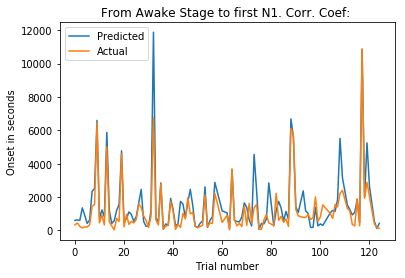

In [22]:
print(res_n1.to_string())
res_n1.plot()
plt.title(str('From Awake Stage to first N1. Corr. Coef: '))
plt.xlabel('Trial number')
plt.ylabel('Onset in seconds')
plt.savefig('W-N1-fig.png')
res_n1.to_csv('W-N1-preds.csv', index=False)  
print('Correlation Coefficient: ',res_n1.Predicted.corr(res_n1.Actual))

## Predict from wake to N2

In [23]:
preds_n2 = []
actual_n2 = []
for i in range(0,all_s):
    if find_smooth(pands[i].iloc[:,1]) == None:
        preds_n2.append(-1)
        actual_n2.append(find_wake_N1(pands[i].iloc[:,0]))
        continue
    samp = pands[i][0:int(find_smooth(pands[i].iloc[:,1]))].iloc[:,1]
    samp1 = samp[samp == 1]
    samp2 = samp[samp == 2]
    preds_n2.append(int(samp1.sum() + samp2.sum()/2))  #another method is using the smooth point
    actual_n2.append(find_wake_N2(pands[i].iloc[:,0]))
res_n2 = pd.DataFrame({'Predicted': preds_n2, 'Actual': actual_n2})
res_n2.Predicted = res_n2.Predicted.apply(convert_to_sec)
res_n2.Actual = res_n2.Actual.apply(convert_to_sec)

In [24]:
print(res_n2[(res_n2.Predicted==-1) ])
res_n2 = res_n2[(res_n2.Predicted!=-1)]
res_n2 = res_n2[(res_n2.Predicted!=0)]
res_n2 = res_n2[(res_n2.Actual!=0)]

    Predicted  Actual
59         -1     540
61         -1     960
92         -1     270


     Predicted  Actual
0          600     450
1          660     540
2          660     600
3         1410    1410
4         1020    1200
5          420     660
6          660     600
7         2430    2400
8         2520    2610
9         6690    6630
10         720     750
11        1290    1590
12         840     900
13        6030    5850
14        1350     750
15         510     420
16         660     570
17        1230    1170
18        1590    1500
19        4860    4890
20         510     360
21         720    1290
22        1290     810
23        1020     720
24         540     540
25         930     840
26        1650    1740
27        2610    2850
28         540    1020
29         240     990
30         270     390
31        1200     960
32       11910   11700
33         840     810
34         510     540
35        2910    3180
36         120     510
37         390     570
38         300     570
39        2010    2160
40        1440    1410
41         270     300
42         

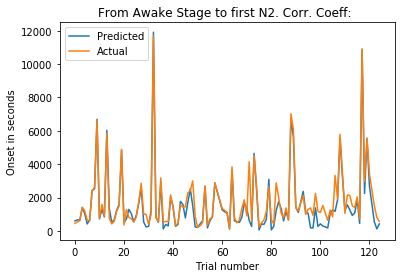

In [25]:
print(res_n2.to_string())
res_n2.plot()
plt.title(str('From Awake Stage to first N2. Corr. Coeff: '))
plt.xlabel('Trial number')
plt.ylabel('Onset in seconds')
plt.savefig('W-N2-fig.png')
res_n2.to_csv('W-N2-preds.csv', index=False)  
print('Correlation Coefficient: ',res_n2.Predicted.corr(res_n2.Actual))

## Confusion Matrix for predictions across all the recorded data

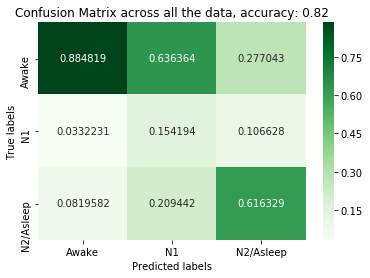

In [26]:
conf = confusion_matrix(np.concatenate(big_y_test), np.concatenate(big_y_pred)) 
conf = conf /conf.astype(np.float).sum(axis=0)
ax= plt.subplot()
acc = accuracy_score(np.concatenate(big_y_test), np.concatenate(big_y_pred))
sns.heatmap(conf, annot=True, ax = ax,fmt = 'g',cmap = 'Greens'); #annot=True to annotate cells
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title(str('Confusion Matrix across all the data, accuracy: ' +str("%.2f" % acc)))
ax.xaxis.set_ticklabels(['Awake', 'N1','N2/Asleep'])
ax.yaxis.set_ticklabels(['Awake', 'N1','N2/Asleep'])
plt.savefig('cf-matrix.png')
plt.show()

## Overall Accuracy

In [27]:
acc = accuracy_score(np.concatenate(big_y_test), np.concatenate(big_y_pred))
print("Overall Model Accuracy: {}".format(acc))

Overall Model Accuracy: 0.8212530820970618


## Scatter plots

#### Predictions without outliers

In [28]:
small_range = res_n2[res_n2.Actual < 6000]

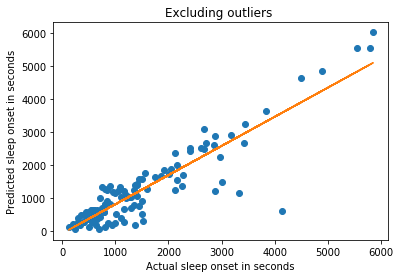

In [29]:
plt.title('Excluding outliers ')
plt.plot(small_range.Actual,small_range.Predicted,'o')
m, b = np.polyfit(small_range.Actual, small_range.Predicted, 1)
plt.plot(small_range.Actual, m*small_range.Actual + b)
plt.xlabel('Actual sleep onset in seconds')
plt.ylabel('Predicted sleep onset in seconds')
plt.savefig('scatter-no-outliers.png')
plt.show()

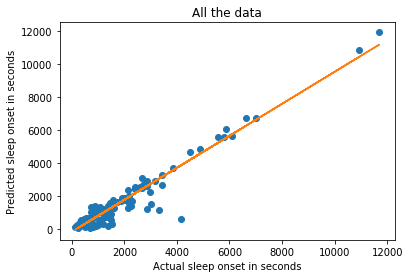

In [30]:
plt.title('All the data')
plt.plot(res_n2.Actual,res_n2.Predicted,'o')
m, b = np.polyfit(res_n2.Actual, res_n2.Predicted, 1)
plt.plot(res_n2.Actual, m*res_n2.Actual + b)
plt.xlabel('Actual sleep onset in seconds')
plt.ylabel('Predicted sleep onset in seconds')
plt.savefig('scatter-all.png')
plt.show()